# **Link Neural data to Behavior**

In [8]:
%load_ext autoreload
%autoreload 2

# **Neural Data Analysis for Visual Working Memory**
This notebook analyzes neural data from non-human primates performing a visual working memory task. The analysis includes:
- Loading neural and behavior data.
- Computing neuron reliability.
- Training regression models.
- Evaluating prediction accuracy.

**Author:** Soroush  
**Date:** 6 March


In [9]:
# Standard Libraries
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Statistics
from sklearn.linear_model import Ridge, RidgeCV
from scipy.stats import pearsonr, sem, ttest_rel, zscore
from scipy.io import loadmat

from functions import *

## **Loading Data**
We load:
- **Neural data** from an mat file (`.mat`).
- **Behavioral data** from a CSV file (`.h5`).
- Neural activity will be extracted in a specific time window (70-170ms).


- 41 timebins -> duration of each timebins is 30ms
- we have active and passive data in this dataset
- here we only have 400ms, 800ms, and 1200ms delays
- The whole duration of our signals is from 0 to 1200ms
- r4 (400ms), r5(800ms), and r6(1200ms) are active data.

In [38]:
# Load Neural Data
neural_data_path = "mag_wm_data.mat"
print_hdf5_structure(neural_data_path)

contents = [f"r{i}" for i in range(1, 7)]
neural_data = {}
for content in contents:
    neural_data[content] = print_hdf5_contents(neural_data_path, content) # Change the name of the functions
    print(f'{content}: {neural_data[content].shape}')
    print(f'{content}: {neural_data[content].mean()}') # -> all data is the same
    print(f'{content}: {neural_data[content].std()}') # -> how to perform analysis
# Load Behavioral Data

Dataset: r1
Dataset: r2
Dataset: r3
Dataset: r4
Dataset: r5
Dataset: r6
r1: (41, 200, 192, 16)
r1: 0.0032395863400919286
r1: 0.1576788331567779
r2: (41, 200, 192, 16)
r2: -0.0014614441534778256
r2: 0.15676936809148603
r3: (41, 200, 192, 16)
r3: -0.0061656802699063635
r3: 0.15258091450485756
r4: (41, 200, 192, 16)
r4: 0.005187397447318521
r4: 0.15073336805059473
r5: (41, 200, 192, 16)
r5: 0.0069516938387696355
r5: 0.15172891144474526
r6: (41, 200, 192, 16)
r6: 0.00826448365890365
r6: 0.15185616359429652


## **Extracting Relevant Time Window**
We select the neural activity between 70-170ms for analysis.

### **Prompt for ChatGPT:**

**"I have neural data in the shape (repetitions, images, neural_sites, time_bins), where:**
- **repetitions**: Number of trials per image.
- **images**: Different visual stimuli presented to the subject.
- **neural_sites**: Number of electrode recording sites.
- **time_bins**: Time points from stimulus onset (e.g., 0-250 ms).

I want to generate a **Jupyter Notebook cell** to:
1. **Compute the Peri-Stimulus Time Histogram (PSTH)**:
   - Average the firing rates across repetitions and neural sites.
   - Compute separate PSTHs for two conditions: **Control images** and **Challenge images** (I will provide their indices).
   - Normalize the firing rates by dividing each PSTH by its peak value.
   - Apply a **Gaussian smoothing filter** to the PSTH to reduce noise.

2. **Identify Key Response Latencies**:
   - **t_onset (onset latency)**: The first significant rise in neural activity.
   - **t_peak (peak latency)**: The time when the firing rate reaches its maximum.
   - Use a derivative-based method to estimate **t_onset**, where the response first significantly increases.
   - Find **t_peak** as the time bin with the maximum firing rate.

3. **Plot the Population Response**:
   - **X-axis:** Time from stimulus onset (ms).
   - **Y-axis:** Normalized population firing rate.
   - **Two curves**: 
     - **Control images (blue)**
     - **Challenge images (red)**
   - **Vertical dashed lines**:
     - One for **t_onset (onset latency)** of each condition.
     - One for **t_peak (peak latency)** of each condition.
   - Add a **legend** and proper labels for clarity.

4. **Technical Requirements**:
   - Use Python with **NumPy, Matplotlib, and SciPy** for calculations and visualization.
   - Ensure the code is modular and easy to adjust (e.g., allow changing smoothing levels).
   - Assume the neural data is stored in a variable called `neural_data`, and control/challenge image indices will be predefined.

Generate a **Jupyter Notebook cell** that accomplishes all of the above."

avg_firing_rate: (16,)


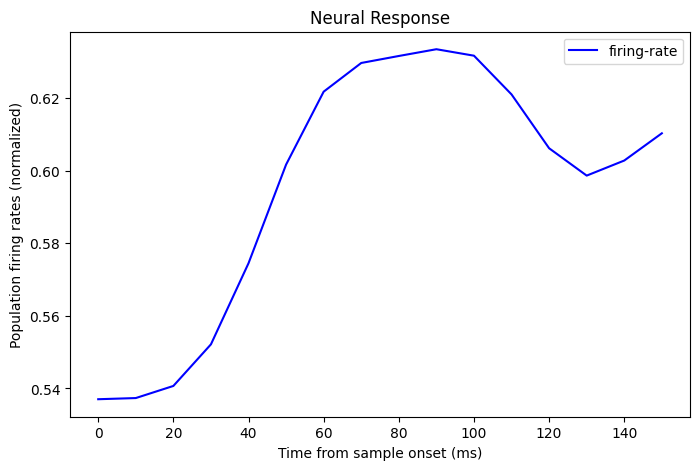

In [39]:
# Plot Neural Data
# data shape -> (41, 200, 192, 16) repetitions, images, neural_sites, time_bins
# Average across repetitions, images, and neural sites

avg_firing_rate = np.mean(neural_data["r1"], axis=(0, 1, 2))  # Shape: (time_bins,)
print(f"avg_firing_rate: {avg_firing_rate.shape}")

# Normalize to peak value
avg_firing_rate /= np.max(avg_firing_rate)

# Apply Gaussian smoothing
smoothing = 2
avg_firing_rate = scipy.ndimage.gaussian_filter1d(avg_firing_rate, sigma=smoothing)

# Time axis (assuming time_bins correspond to 1 ms intervals)
time_bins = np.arange(neural_data["r1"].shape[-1]) * 10

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(time_bins, avg_firing_rate, label="firing-rate", color="blue")
plt.xlabel("Time from sample onset (ms)")
plt.ylabel("Population firing rates (normalized)")
plt.legend()
plt.title("Neural Response")
plt.show()

In [41]:
contents = [f"r{i}" for i in range(1, 7)]
avg_firing_rates = {content: np.mean(neural_data[content], axis=(0, 1, 2)) for content in contents}

# Find maximum
temp_max_list = np.max([np.max(item) for item in avg_firing_rates.values()])



## **Neuron Reliability Analysis**
We calculate reliability using split-half correlations and filter out unreliable neurons.

### Questions
1. How to select the neural reliability threshold?

neural: (200, 192, 41)


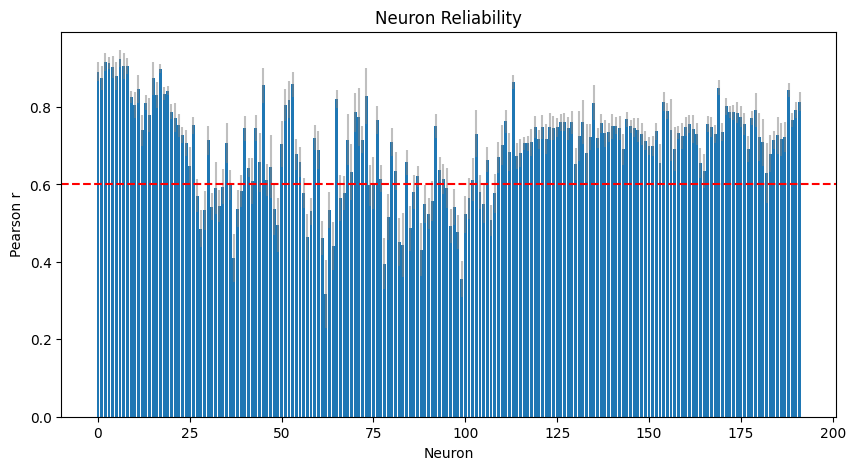

In [43]:
def neuron_reliability(data, runs=20):
    neurons_list = list(np.split(data, data.shape[1], axis=1))
    e_array = np.empty((20, data.shape[1]))
    
    for i in range(len(neurons_list)):
        np.random.seed(i)
        our_neuron = np.squeeze(neurons_list[i])
        for x in range(runs):
            random_indices = np.random.choice(data.shape[2], size=data.shape[2], replace=False)
            m_1 = np.nanmean(our_neuron[:, random_indices[:data.shape[2]//2]], axis=1)
            m_2 = np.nanmean(our_neuron[:, random_indices[data.shape[2]//2:]], axis=1)
            R = pearsonr(m_1, m_2)[0]
            e_array[x, i] = 2 * R / (1 + R)
    
    m_n = np.mean(e_array, axis=0)
    s_n = np.std(e_array, axis=0)
    return m_n, s_n

neural = neural_data["r1"].copy() # 41, 200, 192, 16 reps, images, neural_sites, time_bins
neural = np.nanmean(neural, axis=3) # take average over time_bins
neural = np.transpose(neural, axes=(1, 2, 0))
print(f"neural: {neural.shape}")

# Compute Neuron Reliability
rel, std_rel = neuron_reliability(neural)

# Plot Reliability
plt.figure(figsize=(10,5))
plt.bar(range(len(rel)), rel, yerr=std_rel, error_kw=dict(ecolor='grey', alpha=0.5))
plt.axhline(y=0.6, color='r', linestyle='--') # 
plt.xlabel('Neuron')
plt.ylabel('Pearson r')
plt.title('Neuron Reliability')
plt.show()


In [34]:
rel.shape

(192,)

## **Filtering Reliable Neurons**
We only keep neurons with reliability > 0.2.


In [ ]:
def reliability_filtering(neural_data, mean_neuron_correlation, metric=0.2):
    b_index = mean_neuron_correlation > metric
    reliable_data = neural_data[:, b_index, :]
    return reliable_data

# Filter Neurons
s5_neural = reliability_filtering(neural, rel, metric=0.2)
print("Filtered Neural Data Shape:", s5_neural.shape)

# Normalize Data
s5_neural = zscore(s5_neural, axis=1)


## **Training Ridge Regression Model**
We train a Ridge regression model to predict x-positions from neural data.


In [ ]:
# Reduce dimensionality (average across repetitions)
s5_neural_for_preds = np.nanmean(s5_neural, axis=2)

# Train the regressor
alpha_values = [0.01, 0.1, 1, 10, 100]
n_folds = 4
n_reps = 36
s5_regressors = {}
s5_em_array = np.empty((___.shape[0], n_reps))
s5_reg_rels = np.empty((n_reps, n_folds))

for x in range(n_reps):
    for i in range(n_folds):
        train, test = regression_indices(___.shape[0], number_of_groups=n_folds, test_group=i, SEED=x)
        X_train, y_train = s5_neural_for_preds[train, :], ____[train]
        X_test = s5_neural_for_preds[test, :]

        ridge_cv = RidgeCV(alphas=alpha_values).fit(X_train, y_train)
        best_alpha = ridge_cv.alpha_

        model = Ridge(alpha=best_alpha).fit(X_train, y_train)
        s5_regressors[f"reg_{x}_{i}"] = model
        s5_em_array[test, x] = np.squeeze(model.predict(X_test))


## **Evaluating Model Predictions**
We assess the model’s performance by computing correlation with ground truth.


In [ ]:
s5_preds = np.nanmean(s5_em_array, axis=1)
s5_preds_sem = sem(s5_em_array, axis=1)

# Compute correlation
corr = np.array([pearsonr(np.squeeze(____), s5_em_array[:, p])[0] for p in range(n_reps)])
s5_corr = np.nanmean(corr)
s5_corr_sem = sem(corr)

print(f'Average Correlation: {s5_corr:.2f} ± {s5_corr_sem:.2f}')

# Plot predictions vs ground truth
plt.figure(figsize=(6,6))
plt.errorbar(s5_preds, ____, xerr=s5_preds_sem, fmt='o', color='darkslateblue')
plt.plot(___, ___, color='black', linestyle='--')
plt.xlabel('Decoded X Positions')
plt.ylabel('Ground Truth X Positions')
plt.title('Prediction vs Ground Truth')
plt.show()
